In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'    

In [3]:
import numpy as np
import torch
torch.set_num_threads(1)   # also comment out os.environ['OPENBLAS_NUM_THREADS'] = '1' above for multi threaded

from torch.nn import Module
from tqdm import tqdm

In [4]:
from models.CaloClouds_2 import CaloClouds_2


In [5]:
import matplotlib.pyplot as plt

In [7]:
from configs import Configs
cfg = Configs()
kdiffusion=True   # EDM vs DDPM diffusion
cfg.dropout_rate = 0.0
cfg.latent_dim = 0
cfg.residual = False

In [8]:

# # checkpoint = torch.load(cfg.logdir + '/' + 'CD_2024_03_01__13_36_47/ckpt_0.000000_1090000.pt', map_location=torch.device(cfg.device))   # max 1200000
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_ClusteredDS_Pretrained2024_03_27__00_23_43/ckpt_0.000000_2150000.pt', map_location=torch.device(cfg.device))   # max 1200000

# model = CaloClouds_2(cfg, distillation = True).to(torch.device('cpu'))
# model.load_state_dict(checkpoint['others']['model_ema'])
# model.eval()

In [15]:
from pyro.nn import ConditionalDenseNN, DenseNN
import pyro.distributions as dist
import pyro.distributions.transforms as T
from models.custom_pyro import ConditionalAffineCouplingTanH

import torch
import torch.nn as nn

def compile_HybridTanH_model(num_blocks, num_inputs, num_cond_inputs, device):
    # the latent space distribution: choosing a 2-dim Gaussian
    base_dist = dist.Normal(torch.zeros(num_inputs).to(device), torch.ones(num_inputs).to(device))

    input_dim = num_inputs
    count_bins = 8
    transforms = []
    transforms2 = []
      
    input_dim = num_inputs
    split_dim = num_inputs//2
    param_dims1 = [input_dim-split_dim, input_dim-split_dim]
    param_dims2 = [input_dim * count_bins, input_dim * count_bins, input_dim * (count_bins - 1), input_dim * count_bins]

    torch.manual_seed(42)   # important to reproduce the permutations 

    for i in range(num_blocks):
        

                    
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        hypernet = DenseNN(num_cond_inputs, [input_dim*4, input_dim*4], param_dims2)
        ctf = T.ConditionalSpline(hypernet, input_dim, count_bins)
        transforms2.append(ctf)
        transforms.append(ctf)
        

        

        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        
    modules = nn.ModuleList(transforms2)

#     flow_dist = dist.ConditionalTransformedDistribution(base_dist, transforms)

    return modules, transforms

In [16]:
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro import poutine
import pyro.distributions as dist

# from models.shower_flow import compile_HybridTanH_model

device = torch.device('cpu')

flow_model, flow_transforms = compile_HybridTanH_model(num_blocks=4, 
                                           num_inputs=62, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=4, device=device)  # num_cond_inputs
# checkpoint = torch.load('/gpfs/dust/maxwell/user/akorol/logs/point-clouds-angular/SF/angular_ShowerFlow_best.pth', map_location=torch.device('cpu'))   # trained about 350 epochs
checkpoint = torch.load('/data/dust/user/akorol/maxwell.merged/logs/point-clouds-angular/SF_new/angular_ShowerFlow_best.pth', map_location=device)   # trained about 350 epochs

flow_model.load_state_dict(checkpoint['model'])
flow_model.eval()
flow_model.requires_grad_(False)


class Flow_run(PyroModule):
    def __init__(self, flow_transforms, cond):
        super().__init__()
        self.base_dist = dist.Normal(torch.zeros(num_inputs).to(device), torch.ones(num_inputs).to(device))
        self.flow_dist = PyroSample(lambda self: dist.ConditionalTransformedDistribution(self.base_dist, flow_transforms).condition(cond).expand([1]).to_event(1))

    def forward(self):
        return self.flow_dist

cond_E = torch.FloatTensor(1, 1).uniform_(50, 50)
direction = torch.FloatTensor(1,3).uniform_(0, 1)
context = torch.cat((cond_E, direction), 1)
num_inputs = 62

with torch.no_grad():
    pyro_trace = poutine.trace(Flow_run(flow_transforms, context)).get_trace()


class Container(Module):
    def __init__(self, model, pyro_trace, flow_transforms, num_inputs):
        super().__init__()
        self.model = model
        self.pyro_trace = pyro_trace
        self.flow_transforms = flow_transforms
        self.num_inputs = num_inputs

    def forward(self, cond):
        with torch.no_grad():
            pyro_replay = poutine.replay(self.model, self.pyro_trace)(self.flow_transforms, cond) #, self.batch_size)
            model_trace = poutine.trace(pyro_replay).get_trace()

            return model_trace.nodes["_RETURN"]['value']
        
traced_flow = Container(Flow_run, pyro_trace, flow_transforms, num_inputs) #, batch_size)

# new SF

In [8]:
import sys
sys.path.append('../point-cloud-diffusion/')

In [9]:
import numpy as np
import torch

# Simple shower configs for
# shower_flow_fixed_input_norms = True
# shower_flow_inputs = [ "cog_x", "cog_y", "clusters_per_layer", "energy_per_layer"]
# and
# shower_flow_num_blocks = 2
from pointcloud.config_varients import caloclouds_3
from pointcloud.utils import showerflow_utils
from pointcloud.models import shower_flow

configs = caloclouds_3.Configs()
# only if you are on a machine without CUDA
configs.device = "cpu"
# point to your events, because then functions that check the metadata check the right metadata
configs.dataset_path = "/data/dust/user/akorol/data/AngularShowers_RegularDetector/hdf5_for_CC/sim-E1261AT600AP180-180_file_{}slcio.hdf5"
configs.n_dataset_files = 88
# This lets you algorithmically get the input and conditioning dimensions. Then if we change them (taking out cog_z for example) you don't need to change other code.
cond_mask = showerflow_utils.get_cond_mask(configs)
input_mask = showerflow_utils.get_input_mask(configs)
# The version is the operations inside a block, you can also see it in the saved model name
version = "alt1"
constructor = shower_flow.versions_dict[version]
# Get ourselves an untrained model with the right architecture
flow_model, dist, flow_transforms = constructor(
    num_blocks=2,
    num_inputs=np.sum(input_mask),
    num_cond_inputs=np.sum(cond_mask),
    device=configs.device,
)
# load the weights
model_path = (
    "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/"
    "ShowerFlow_alt1_nb2_"  # block version and number of blocks
    "inputs8070450532247928831_"  # input mask representaiton
    "fnorms_best.pth"  # fnorms = Not normalising by layer with highest value, etc.
)
loaded = torch.load(model_path, map_location=configs.device)
flow_model.load_state_dict(loaded["model"])
# Now make up some conditioning values
context = torch.tensor(
    [[0.572, 0.333, -0.4859, 0.808], [0.00934, -0.522, -0.279, 0.8059]]
)
conditioned = dist.condition(context)
# print(conditioned.sample(torch.Size([len(context)])))

In [10]:
cond_E = torch.FloatTensor(3500, 1).uniform_(50, 50)
direction = torch.FloatTensor(3500, 3).uniform_(0, 1)
context = torch.cat((cond_E, direction), 1)

In [11]:
conditioned = dist.condition(context)

In [15]:
%%timeit
shower = conditioned.sample(torch.Size([len(context)]))

1.51 s ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
from pointcloud.utils.metadata import Metadata

In [13]:
mtd = Metadata(configs)

In [14]:
mtd

Metadata for /data/dust/user/akorol/data/AngularShowers_RegularDetector/hdf5_for_CC/sim-E1261AT600AP180-180_file_{}slcio.hdf5
layer_bottom_pos_hdf5: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
half_cell_size_global: 2.5441665649414062
cell_thickness_global: 0.5250244140625
gun_xyz_pos_hdf5: [   0. 1811.    0.]
orientation: hdf5:xyz==local:xyz
gun_xyz_pos_global: [    0. 18047.   -50.]
orientation_global: hdf5:xyz==global:yzx
layer_bottom_pos_global: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293
 1839.4050293  1848.75       1851.875      1861.2199707  1864.3449707
 1873.68994141 1876.81494141 1886.16003418 1889.28503418 1898.63000488
 1901.75500488 1911.09997559 1914.22497559 1923.56994629 1926.69494629
 1938.14001465 1943.36499023 1954.81005859 1960.03503418 1971.47998047
 1976.70495605 1988.15002441 1993.375      2004.81994629 2010.04504395]
Ymin_global: 1811
Xmin_global: -250
Xmax_g

In [15]:
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro import poutine
import pyro.distributions as dist

device = torch.device('cpu')

flow_model.eval()
flow_model.requires_grad_(False)


class Flow_run(PyroModule):
    def __init__(self, flow_transforms, cond):
        super().__init__()
        self.base_dist = dist.Normal(torch.zeros(num_inputs).to(device), torch.ones(num_inputs).to(device))
        self.flow_dist = PyroSample(lambda self: dist.ConditionalTransformedDistribution(self.base_dist, flow_transforms).condition(cond).expand([1]).to_event(1))

    def forward(self):
        return self.flow_dist

cond_E = torch.FloatTensor(1, 1).uniform_(50, 50)
direction = torch.FloatTensor(1, 3).uniform_(0, 1)
context = torch.cat((cond_E, direction), 1)
num_inputs = 62

with torch.no_grad():
    pyro_trace = poutine.trace(Flow_run(flow_transforms, context)).get_trace()


class Container(Module):
    def __init__(self, model, pyro_trace, flow_transforms, num_inputs):
        super().__init__()
        self.model = model
        self.pyro_trace = pyro_trace
        self.flow_transforms = flow_transforms
        self.num_inputs = num_inputs

    def forward(self, cond):
        with torch.no_grad():
            pyro_replay = poutine.replay(self.model, self.pyro_trace)(self.flow_transforms, cond) #, self.batch_size)
            model_trace = poutine.trace(pyro_replay).get_trace()

            return model_trace.nodes["_RETURN"]['value']
        
traced_flow = Container(Flow_run, pyro_trace, flow_transforms, num_inputs) #, batch_size)

In [24]:
flow_module = torch.jit.trace_module(traced_flow, {"forward": context}, check_trace=True)

In [25]:
samples = flow_module(context)[0].numpy()

In [20]:
# cogx,
# cogy,
# 30 points
# 30 energies

# old SF inferer

In [18]:
# class Inferrer(Module):
#     def __init__(self, denoiser, shower_flow):
#         super().__init__()
        
#         self.energy_max = 126.7 # max energy of the dataset in GeV
# #         self.max_num_points = 8150 # 8150 max num points to match occupansy
#         self.max_num_points = 7077
# #         self.max_num_points = 6000
    
#         self.vis_energy_max = 3.430511 * 1000 # in MeV
#         self.vis_energy_min = 0.013 * 1000 # in MeV
#         self.scale_factor = 1 # need to extend to energy and angle depended scale factor
#         self.Xmin = -250
#         self.Xmax = 250
#         self.Ymin = -250
#         self.Ymax = 250
#         self.EIR = 1804.7 # ecal inner radius in mm from the IP
        
#         self.layer_bottom_pos = torch.tensor([   1811.34020996, 1814.46508789, 1823.81005859, 1826.93505859,
#                                                  1836.2800293 , 1839.4050293 , 1848.75      , 1851.875     ,
#                                                  1861.2199707 , 1864.3449707 , 1873.68994141, 1876.81494141,
#                                                  1886.16003418, 1889.28503418, 1898.63000488, 1901.75500488,
#                                                  1911.09997559, 1914.22497559, 1923.56994629, 1926.69494629,
#                                                  1938.14001465, 1943.36499023, 1954.81005859, 1960.03503418,
#                                                  1971.47998047, 1976.70495605, 1988.15002441, 1993.375     ,
#                                                  2004.81994629, 2010.04504395])
#         self.layer_bottom_pos = self.layer_bottom_pos - self.EIR
#         self.cell_thickness = 0.5250244140625 # in mm
# #         self.z_positions = self.layer_bottom_pos+self.cell_thickness/2
#         self.dist_to_layers = self.layer_bottom_pos + self.cell_thickness/2
        
#         self.z_positions = torch.arange(30, dtype=torch.float)

#         self.denoiser = denoiser
#         self.shower_flow = shower_flow

#     def get_direction(self, theta, phi):

# #         theta = torch.tensor(theta, dtype=torch.float32)
# #         phi = torch.tensor(phi, dtype=torch.float32)
    
#         theta = theta/180. * torch.pi  # theta in radians
#         phi = phi/180. * torch.pi  # phi in radians
        
#         px = torch.cos( phi ) * torch.sin( theta ) 
#         py = torch.sin( phi ) * torch.sin( theta )
#         pz = torch.cos( theta ) 
        
#         return torch.tensor([float(px.item()), float(py.item()), float(pz.item())])
    
#     def get_shift(self, theta, phi, l: int):
        
# #         theta = torch.tensor(theta, dtype=torch.float32)
# #         phi = torch.tensor(phi, dtype=torch.float32)
        
#         theta = theta/180. * torch.pi  # theta in radians
#         phi = phi/180. * torch.pi  # phi in radians
        
#         r = self.dist_to_layers[l] / torch.cos(theta)
#         x_shift = r * torch.sin(theta) * torch.cos(phi)
#         y_shift = r * torch.sin(theta) * torch.sin(phi)
        
#         return x_shift, y_shift
    
#     def get_cog(self, x,y,e):
#         cog_x = torch.sum((x * e), dim=1) / e.sum(dim=1)
#         cog_y = torch.sum((y * e), dim=1) / e.sum(dim=1)
#         return cog_x, cog_y
    

#     @torch.jit.script_method
#     def forward(self, energy, theta, phi):
#         """
#         Args:
#             energy:  Energy of the shower [MeV].
#             theta:   Theta angle of the shower.
#             phi:     Phi angle of the shower.
#         Every input is in local coordinates.
#         """
# #         cond_E = torch.FloatTensor(1, 1).uniform_(energy, energy) / self.energy_max
#         cond_E = (energy / self.energy_max).view(1,1)
#         direction = self.get_direction(theta, phi).unsqueeze(0)

#         context = torch.cat((cond_E, direction), 1)
        
#         with torch.no_grad():
#             samples = self.shower_flow(context)
            
#         e = torch.ones((1, 1)).to(device) * energy
#         p = torch.ones((1, 3)).to(device) * direction

#         e = e / 100 * 2 -1   # max incident energy: 100 GeV

#         cond_feats = torch.cat([e, p], -1)
        
#         num_clusters = torch.clip((samples[:, 0] * self.max_num_points).reshape(1, 1), 1, None) 
#         energies = torch.clip((samples[:, 1] * self.vis_energy_max).reshape(1, 1), self.vis_energy_min, None) # in MeV (clip to a minimum energy of 13 MeV)
        
#         cog_x = samples[:, 2]
#         cog_y = samples[:, 3]
#         cog_z = samples[:, 4]
        
#         clusters_per_layer_gen = torch.clip(samples[:, 2:32], 0, 1)  #  B,30
#         e_per_layer_gen = torch.clip(samples[:, 32:], 0, 1) 
        
# #         clusters_per_layer_gen = torch.clip(samples[:, 5:35], 0, 1)  #  B,30
# #         e_per_layer_gen = torch.clip(samples[:, 35:], 0, 1) 
        
#         num_clusters = (num_clusters * self.scale_factor).int()
        
        
#         clusters_per_layer_gen = (clusters_per_layer_gen / torch.sum(clusters_per_layer_gen, 1, True) * num_clusters).int() # B,30
#         e_per_layer_gen = e_per_layer_gen / torch.sum(e_per_layer_gen, 1, True) * energies
        
#         max_num_clusters = torch.sum(clusters_per_layer_gen)

#         with torch.no_grad():
#             fake_shower = self.denoiser(cond_feats, max_num_clusters)
        
#         z_flow = torch.repeat_interleave(self.z_positions, clusters_per_layer_gen[0], dim=0)
#         idx_dm = torch.argsort(fake_shower[0, :, 2])
#         fake_shower[0, :, 2][idx_dm] = z_flow
        
        
#         fake_shower[:, :, 0] = (fake_shower[:, :, 0] + 1) / 2
#         fake_shower[:, :, 1] = (fake_shower[:, :, 1] + 1) / 2

#         fake_shower[:, :, 0] = fake_shower[:, :, 0] * (self.Xmax - self.Xmin) - self.Xmax
#         fake_shower[:, :, 1] = fake_shower[:, :, 1] * (self.Ymax - self.Ymin) - self.Ymax
                
#         cog = self.get_cog(fake_shower[:, :, 0], fake_shower[:, :, 1], fake_shower[:, :, 3])
#         fake_shower[:, :, 0] = fake_shower[:, :, 0] - (cog[0] - cog_x).unsqueeze(1)
#         fake_shower[:, :, 1] = fake_shower[:, :, 1] - (cog[1] - cog_y).unsqueeze(1)
        
# #         fake_shower[:, :, 0] = fake_shower[:, :, 0] - cog[0].unsqueeze(1)
# #         fake_shower[:, :, 1] = fake_shower[:, :, 1] - cog[1].unsqueeze(1)
        
        
#         for j in range(len(self.z_positions)):
#             mask = fake_shower[0, :, 2] == self.z_positions[j]
#             fake_shower[0, :, -1][mask] = fake_shower[0, :, -1][mask] / fake_shower[0, :, -1][mask].sum() * e_per_layer_gen[0, j]
            
#             x_shift, y_shift = self.get_shift(theta, phi, j)
#             fake_shower[0, :, 0][mask] = (fake_shower[0, :, 0][mask] + x_shift).view(-1)
#             fake_shower[0, :, 1][mask] = (fake_shower[0, :, 1][mask] + y_shift).view(-1)

#         fake_shower = fake_shower[0].view(-1)
        
#         fake_shower = torch.concat((clusters_per_layer_gen.view(-1), fake_shower))
        
#         return fake_shower

# new SF inferer

In [17]:
class Inferrer(Module):
    def __init__(self, denoiser, shower_flow):
        super().__init__()
        
        self.energy_max = 127 # max energy of the dataset in GeV
#         self.max_num_points = 8150 # 8150 max num points to match occupansy
        self.max_num_points = 7864
        # self.scale_factor = 0.85 
        # self.scale_factor = 0.7 # need to extend to energy and angle depended scale factor
        self.scale_factor = 0.64
        # self.scale_factor = 1.0
#         self.max_num_points = 6000
    
        self.vis_energy_max = 3.4 * 1000 # in MeV
        self.Xmin = -250
        self.Xmax = 250
        self.Ymin = -250
        self.Ymax = 250
        self.Xmean, self.Ymean, self.Zmean = -0.0074305227, -0.21205868, 12.359252
        self.Xstd, self.Ystd, self.Zstd = 21.608465, 22.748442, 5.305082
        self.Emean, self.Estd = -1.5300317, 1.2500798
        self.EIR = 1804.7 # ecal inner radius in mm from the IP
        
        self.layer_bottom_pos = torch.tensor([   1811.34020996, 1814.46508789, 1823.81005859, 1826.93505859,
                                                 1836.2800293 , 1839.4050293 , 1848.75      , 1851.875     ,
                                                 1861.2199707 , 1864.3449707 , 1873.68994141, 1876.81494141,
                                                 1886.16003418, 1889.28503418, 1898.63000488, 1901.75500488,
                                                 1911.09997559, 1914.22497559, 1923.56994629, 1926.69494629,
                                                 1938.14001465, 1943.36499023, 1954.81005859, 1960.03503418,
                                                 1971.47998047, 1976.70495605, 1988.15002441, 1993.375     ,
                                                 2004.81994629, 2010.04504395])
        self.layer_bottom_pos = self.layer_bottom_pos - self.EIR
        self.cell_thickness = 0.5250244140625 # in mm
        # self.z_positions = self.layer_bottom_pos+self.cell_thickness/2
        self.dist_to_layers = self.layer_bottom_pos + self.cell_thickness/2
        
        self.z_positions = torch.arange(30, dtype=torch.float)

        self.denoiser = denoiser
        self.shower_flow = shower_flow
        self.mean_cog = torch.tensor([-4.06743696e-03, -2.27790998e-01,  1.10137465e+01])
        self.std_cog = torch.tensor([1.24559791, 0.95357278, 2.59475371])


        self.e_per_layer_coef = torch.tensor([1.05721914, 1.09306586, 1.00216758, 0.99775701, 1.02095665,
       1.02951496, 1.03184801, 1.03004719, 1.01795327, 1.02442725,
       1.02187786, 1.01965737, 1.01642331, 1.01536415, 1.01062916,
       1.00443355, 1.02087608, 0.9956956 , 0.99083067, 0.99447089,
       0.97538481, 0.96292943, 0.9600461 , 0.95002176, 0.95056312,
       0.93167581, 0.9229753 , 0.95183724, 0.89684147, 0.99899776])
        

    def get_direction(self, theta, phi):

#         theta = torch.tensor(theta, dtype=torch.float32)
#         phi = torch.tensor(phi, dtype=torch.float32)
    
        theta = theta/180. * torch.pi  # theta in radians
        phi = phi/180. * torch.pi  # phi in radians
        
        px = torch.cos( phi ) * torch.sin( theta ) 
        py = torch.sin( phi ) * torch.sin( theta )
        pz = torch.cos( theta ) 
        
        return torch.tensor([float(px.item()), float(py.item()), float(pz.item())])
    
    def get_shift(self, theta, phi, l: int):
        
#         theta = torch.tensor(theta, dtype=torch.float32)
#         phi = torch.tensor(phi, dtype=torch.float32)
        
        theta = theta/180. * torch.pi  # theta in radians
        phi = phi/180. * torch.pi  # phi in radians
        
        r = self.dist_to_layers[l] / torch.cos(theta)
        x_shift = r * torch.sin(theta) * torch.cos(phi)
        y_shift = r * torch.sin(theta) * torch.sin(phi)
        
        return x_shift, y_shift
    
    def get_cog(self, x,y,e):
        cog_x = torch.sum((x * e), dim=1) / e.sum(dim=1)
        cog_y = torch.sum((y * e), dim=1) / e.sum(dim=1)
        return cog_x, cog_y
    

    @torch.jit.script_method
    def forward(self, energy, theta, phi):
        """
        Args:
            energy:  Energy of the shower [MeV].
            theta:   Theta angle of the shower.
            phi:     Phi angle of the shower.
        Every input is in local coordinates.
        """
#         cond_E = torch.FloatTensor(1, 1).uniform_(energy, energy) / self.energy_max
        cond_E = (energy / self.energy_max).view(1,1)
        direction = self.get_direction(theta, phi).unsqueeze(0)
        # print("SF direction: ", direction)
        # print("SF cond_E: ", cond_E)
        context = torch.cat((cond_E, direction), 1)
        
        with torch.no_grad():
            samples = self.shower_flow(context)
            
        # e = torch.ones((1, 1)) * energy
        # p = torch.ones((1, 3)) * direction
        # e = e / 100 * 2 -1   # max incident energy: 100 GeV
        # cond_feats = torch.cat([e, p], -1)
        cond_feats = context
                
        cog_x = samples[:, 0] * self.std_cog[0] + self.mean_cog[0]
        cog_y = samples[:, 1] * self.std_cog[1] + self.mean_cog[1]

        clusters_per_layer_cond = torch.clip(samples[:, 2:32], 0, None)  #  B,30
        clusters_per_layer_gen = torch.clip(samples[:, 2:32], 0, None) * self.max_num_points / 30 #  B,30
        e_per_layer_gen = torch.clip(samples[:, 32:], 0, None) * self.vis_energy_max / 30
        # e_per_layer_gen = e_per_layer_gen*self.e_per_layer_coef.unsqueeze(0)
        
        # num_clusters = (clusters_per_layer_gen.sum() * self.scale_factor).int()
        num_clusters = clusters_per_layer_gen.sum() * self.scale_factor
        clusters_per_layer_gen = (clusters_per_layer_gen / clusters_per_layer_gen.sum() * num_clusters).int()
        num_clusters = clusters_per_layer_gen.sum()

        # cond_feats = torch.cat((cond_feats, clusters_per_layer_cond), 1)
        with torch.no_grad():
            fake_shower = self.denoiser(cond_feats, num_clusters)
        
        z_flow = torch.repeat_interleave(self.z_positions, clusters_per_layer_gen[0], dim=0)
        idx_dm = torch.argsort(fake_shower[0, :, 2])
        fake_shower[0, :, 2][idx_dm] = z_flow
        
        
        # fake_shower[:, :, 0] = (fake_shower[:, :, 0] + 1) / 2
        # fake_shower[:, :, 1] = (fake_shower[:, :, 1] + 1) / 2
        # fake_shower[:, :, 0] = fake_shower[:, :, 0] * (self.Xmax - self.Xmin) - self.Xmax
        # fake_shower[:, :, 1] = fake_shower[:, :, 1] * (self.Ymax - self.Ymin) - self.Ymax

        # post calibration
        scale_xy = 1.04
        fake_shower[:, :, 0] = fake_shower[:, :, 0]*self.Xstd*2*scale_xy + self.Xmean
        fake_shower[:, :, 1] = fake_shower[:, :, 1]*self.Ystd*2*scale_xy + self.Ymean
        fake_shower[:, :, 3] = torch.exp(fake_shower[:, :, 3]*self.Estd*2 + self.Emean)
        
        # cog calibration
        cog = self.get_cog(fake_shower[:, :, 0], fake_shower[:, :, 1], fake_shower[:, :, 3])
        fake_shower[:, :, 0] = fake_shower[:, :, 0] - (cog[0] - cog_x).unsqueeze(1)
        fake_shower[:, :, 1] = fake_shower[:, :, 1] - (cog[1] - cog_y).unsqueeze(1)
        
        # fake_shower[:, :, 0] = fake_shower[:, :, 0] - cog[0].unsqueeze(1) # test with zero cog
        # fake_shower[:, :, 1] = fake_shower[:, :, 1] - cog[1].unsqueeze(1) # test with zero cog

        for j in range(len(self.z_positions)):
            mask = fake_shower[0, :, 2] == self.z_positions[j]
            fake_shower[0, :, -1][mask] = fake_shower[0, :, -1][mask] / fake_shower[0, :, -1][mask].sum() * e_per_layer_gen[0, j]
            
            x_shift, y_shift = self.get_shift(theta, phi, j)
            fake_shower[0, :, 0][mask] = (fake_shower[0, :, 0][mask] + x_shift).view(-1)
            fake_shower[0, :, 1][mask] = (fake_shower[0, :, 1][mask] + y_shift).view(-1)

        scale_energy = 1.00609194411797
        fake_shower[:, :, 3] = fake_shower[:, :, 3] * scale_energy

        fake_shower = fake_shower[0].view(-1)
        fake_shower = torch.concat((clusters_per_layer_gen.view(-1), fake_shower))

        
        
        return fake_shower

In [18]:
import torch
from torch.nn import Module

from models.common import *
from utils.misc import *

import k_diffusion as K

device = torch.device("cpu")

class CaloClouds_2(Module):

    def __init__(self,):
        super(CaloClouds_2, self).__init__()
        
        self.features = 4
        self.sigma_max = 80 # from configs.py
        
        net = PointwiseNet_kDiffusion(
            point_dim=4, # from configs.py
            context_dim=4 # from configs.py
        )
        
        self.diffusion = Denoiser(
            net,
            sigma_data = 0.5, # from configs.py
            device=device, # from configs.py
            sigma_min=0.002 # from configs.py
        )
    
    @torch.jit.script_method
    def forward(self, cond_feats, num_points: int):

        z = cond_feats  

        x_T = torch.randn([z.size(0), num_points, self.features], device=z.device) * self.sigma_max
        
        x_0 = self.diffusion.forward(x_T, self.sigma_max, context=z)

        return x_0


class Denoiser(Module):
    """A Karras et al. preconditioner for denoising diffusion models."""

    def __init__(self, inner_model, sigma_data=0.5, device='cpu', sigma_min = 0.002):
        super(Denoiser, self).__init__()
        self.inner_model = inner_model
        
        sigma_data = [sigma_data, sigma_data, sigma_data, sigma_data]
        self.sigma_data = torch.tensor(sigma_data, device=device)   # 4,
        self.sigma_min = sigma_min
    
    def get_scalings_for_boundary_condition(self, sigma):   # B,   # for consistency model
        sigma_data = self.sigma_data.expand(sigma.shape[0], -1)   # B, 4
    
        c_skip = sigma_data**2 / (
            (sigma - self.sigma_min) ** 2 + sigma_data**2
        )   # B, 4
        c_out = (
            (sigma - self.sigma_min)
            * sigma_data
            / (sigma**2 + sigma_data**2) ** 0.5
        )   # B, 4
        c_in = 1 / (sigma ** 2 + sigma_data ** 2) ** 0.5  # B, 4
        return c_skip, c_out, c_in
    
    
    @torch.jit.script_method
    def forward(self, input, sigma: int, context):   # same as "denoise" in KarrasDenoiser of CM code
        
        sigma = (
            torch.tensor([sigma] * input.shape[0], dtype=torch.float32)
            .to(input.device)
            .unsqueeze(1)
        )
        
        c_skip, c_out, c_in = [x.unsqueeze(1) for x in self.get_scalings_for_boundary_condition(sigma)]
        

        return self.inner_model(input * c_in, sigma, context) * c_out + input * c_skip
    



class PointwiseNet_kDiffusion(Module):

    def __init__(self, point_dim, context_dim):
        super(PointwiseNet_kDiffusion, self).__init__()
        time_dim = 64
        fourier_scale = 16   # 1 in k-diffusion, 16 in EDM, 30 in Score-based generative modeling

        self.act = F.leaky_relu
        # self.layers = ModuleList([
        #     ConcatSquashLinear(point_dim, 128, context_dim+time_dim),
        #     ConcatSquashLinear(128, 256, context_dim+time_dim),
        #     ConcatSquashLinear(256, 512, context_dim+time_dim),
        #     ConcatSquashLinear(512, 256, context_dim+time_dim),
        #     ConcatSquashLinear(256, 128, context_dim+time_dim),
        #     ConcatSquashLinear(128, point_dim, context_dim+time_dim)
        # ])
        self.layers = ModuleList([
            ConcatSquashLinear(point_dim, 32, context_dim+time_dim),
            ConcatSquashLinear(32, 64, context_dim+time_dim),
            ConcatSquashLinear(64, 128, context_dim+time_dim),
            ConcatSquashLinear(128, 64, context_dim+time_dim),
            ConcatSquashLinear(64, 32, context_dim+time_dim),
            ConcatSquashLinear(32, point_dim, context_dim+time_dim)
        ])

        self.timestep_embed = nn.Sequential(
            K.layers.FourierFeatures(1, time_dim, std=fourier_scale),   # 1D Fourier features --> with register_buffer, so weights are not trained
            nn.Linear(time_dim, time_dim), # this is a trainable layer
        )
    
    @torch.jit.script_method
    def forward(self, x: torch.Tensor, sigma: torch.Tensor, context: torch.Tensor): # inportant to spesify datatypes
        """
        Args:
            x:  Point clouds at some timestep t, (B, N, d).
            sigma:     Time. (B, ).  --> becomes "sigma" in k-diffusion
            context:  Shape latents. (B, F). 
        """
        batch_size = x.size(0)
        sigma = sigma.view(batch_size, 1, 1)          # (B, 1, 1)
        context = context.view(batch_size, 1, -1)   # (B, 1, F)

        # formulation from EDM paper / k-diffusion
        c_noise = sigma.log() / 4  # (B, 1, 1)
        time_emb = self.act(self.timestep_embed(c_noise))  # (B, 1, T)
        
        # time_emb = torch.cat([beta, torch.sin(beta), torch.cos(beta)], dim=-1)  # (B, 1, 3)
        ctx_emb = torch.cat([time_emb, context], dim=-1)    # (B, 1, F+T)   # TODO: might want to add additional linear embedding net for context or only cond_feats

        out = x
        for i, layer in enumerate(self.layers):
            out = layer(ctx=ctx_emb, x=out)
            if i < len(self.layers) - 1:
                out = self.act(out)
        
        return out


class ConcatSquashLinear(Module):
    def __init__(self, dim_in, dim_out, dim_ctx):
        super(ConcatSquashLinear, self).__init__()
        self._layer = Linear(dim_in, dim_out)
        self._hyper_bias = Linear(dim_ctx, dim_out, bias=False)
        self._hyper_gate = Linear(dim_ctx, dim_out)
    
    @torch.jit.script_method
    def forward(self, ctx, x):
        gate = torch.sigmoid(self._hyper_gate(ctx))
        bias = self._hyper_bias(ctx)
        ret = self._layer(x) * gate + bias
        return ret

In [19]:
# cfg.logdir = '/gpfs/dust/maxwell/user/akorol/logs/point-clouds-angular/'
cfg.logdir = '/beegfs/desy/user/akorol/logs/point-clouds/'

In [20]:
cfg.logdir = '/data/dust/user/akorol/beegfs.migration/logs/point-clouds'
# cfg.logdir = '/data/dust/user/akorol/logs/cc3/'


In [21]:
cfg.logdir

'/data/dust/user/akorol/beegfs.migration/logs/point-clouds'

In [22]:
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2024_03_01__13_36_47/ckpt_0.000000_1090000.pt', map_location=torch.device(cfg.device))   # max 1200000
# checkpoint = torch.load(f'{cfg.logdir}/CD_ClusteredDS_Pretrained2024_03_27__00_23_43/ckpt_0.000000_2150000.pt', map_location=torch.device(cfg.device))   # max 1200000
# checkpoint = torch.load(f'{cfg.logdir}/CaloClouds3_dist_50steps_2024_09_19__21_17_03/ckpt_0.000000_120000.pt', map_location=torch.device(cfg.device)) 

# checkpoint = torch.load(f'{cfg.logdir}/CaloClouds3_CD_small_2025_01_06__15_24_11/ckpt_0.000000_402000.pt', map_location=torch.device(cfg.device))   # max 1200000
checkpoint = torch.load(f'{cfg.logdir}/CaloClouds3_CD_small_2025_01_07__08_26_02/ckpt_0.000000_6135000.pt', map_location=torch.device('cpu'))   # max 1200000
# checkpoint = torch.load(f'{cfg.logdir}/CaloClouds3_CM_small_2025_01_10__20_12_49/ckpt_0.000000_6000000.pt', map_location=torch.device(cfg.device))   # max 1200000


model = CaloClouds_2().to(torch.device('cpu'))
model.load_state_dict(checkpoint['others']['model_ema'])
model.eval()

CaloClouds_2(
  (diffusion): Denoiser(
    (inner_model): PointwiseNet_kDiffusion(
      (layers): ModuleList(
        (0): ConcatSquashLinear(
          (_layer): Linear(in_features=4, out_features=32, bias=True)
          (_hyper_bias): Linear(in_features=68, out_features=32, bias=False)
          (_hyper_gate): Linear(in_features=68, out_features=32, bias=True)
        )
        (1): ConcatSquashLinear(
          (_layer): Linear(in_features=32, out_features=64, bias=True)
          (_hyper_bias): Linear(in_features=68, out_features=64, bias=False)
          (_hyper_gate): Linear(in_features=68, out_features=64, bias=True)
        )
        (2): ConcatSquashLinear(
          (_layer): Linear(in_features=64, out_features=128, bias=True)
          (_hyper_bias): Linear(in_features=68, out_features=128, bias=False)
          (_hyper_gate): Linear(in_features=68, out_features=128, bias=True)
        )
        (3): ConcatSquashLinear(
          (_layer): Linear(in_features=128, out_featu

In [27]:
inferrer = Inferrer(model, flow_module)

In [28]:
inferrer.get_direction(torch.tensor(0), torch.tensor(10))

tensor([0., 0., 1.])

In [29]:
inferrer.get_shift(torch.tensor(60), torch.tensor(45), torch.tensor(1))

(tensor(12.2813), tensor(12.2813))

In [30]:
# samples = inferrer(10, 32, 10)

In [31]:
CC2_container_full_load = torch.jit.script(inferrer)

In [42]:
CC2_container = torch.jit.script(inferrer)

torch.jit.save(CC2_container, '/data/dust/user/akorol/chpts/CaloClouds3_CD_small_2025_01_07__08_26_02_ckpt_0.000000_6135000_calibrated_EandOcc.pt')

CC2_container_full_load = torch.jit.load('/data/dust/user/akorol/chpts/CaloClouds3_CD_small_2025_01_07__08_26_02_ckpt_0.000000_6135000_calibrated_EandOcc.pt')

In [79]:
%%timeit
fake_shower = CC2_container_full_load(torch.tensor(20), torch.tensor(0), torch.tensor(0))
fake_shower = fake_shower.numpy()

39 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%%timeit
fake_shower = CC2_container_full_load(torch.tensor(50), torch.tensor(0), torch.tensor(0))
# fake_shower = fake_shower.numpy()

17.2 ms ± 78.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%%timeit
fake_shower = CC2_container_full_load(torch.tensor(2.5), torch.tensor(0), torch.tensor(0))

11.9 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%%timeit
fake_shower = CC2_container_full_load(torch.tensor(2.5), torch.tensor(0), torch.tensor(0))

18.9 ms ± 62.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%%timeit
fake_shower = CC2_container_full_load(torch.tensor(2.5), torch.tensor(0), torch.tensor(0))

14.6 ms ± 84.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
fake_shower = CC2_container_full_load(2.5, 0, 0)

The slowest run took 379.04 times longer than the fastest. This could mean that an intermediate result is being cached.
3.08 s ± 6.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
fake_shower = CC2_container_full_load(1, 0, 0)

33.8 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
fake_shower = CC2_container_full_load(10, 0, 0)

48.1 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%%timeit
fake_shower = CC2_container_full_load(50, 0, 0)

117 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [328]:
%%timeit
fake_shower = CC2_container_full_load(torch.tensor(50), torch.tensor(0), torch.tensor(0))

67.6 ms ± 7.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [278]:
CC2_container_full_load.half();

In [290]:
fake_shower = CC2_container_full_load(torch.tensor(50).half(), torch.tensor(0).half(), torch.tensor(0).half())

In [291]:
fake_shower.dtype

torch.float32

In [75]:
x = []
y = []
e = []
for i in tqdm(range(10)):
    fake_shower = CC2_container_full_load(torch.tensor(100), torch.tensor(0), torch.tensor(0))
    fake_shower = fake_shower.numpy()
    x.append(fake_shower[30::4])
    y.append(fake_shower[31::4])
    e.append(fake_shower[33::4])

100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


In [63]:
x = []
y = []
e = []
for i in tqdm(range(10)):
    fake_shower = CC2_container_full_load(torch.tensor(100), torch.tensor(0), torch.tensor(0))
    fake_shower = fake_shower.numpy()
    x.append(fake_shower[30::4])
    y.append(fake_shower[31::4])
    e.append(fake_shower[33::4])

100%|██████████| 10/10 [00:00<00:00, 40.13it/s]


In [33]:
x = []
y = []
e = []
for i in tqdm(range(2000)):
    fake_shower = CC2_container_full_load(torch.tensor(50), torch.tensor(0), torch.tensor(0))
    fake_shower = fake_shower.numpy()
    x.append(fake_shower[30::4])
    y.append(fake_shower[31::4])
    e.append(fake_shower[33::4])

100%|██████████| 2000/2000 [00:39<00:00, 50.34it/s]


In [69]:
x = []
y = []
e = []
for i in tqdm(range(100)):
    fake_shower = CC2_container_full_load(torch.tensor(50), torch.tensor(0), torch.tensor(0))
    fake_shower = fake_shower.numpy()
    x.append(fake_shower[30::4])
    y.append(fake_shower[31::4])
    e.append(fake_shower[33::4])

100%|██████████| 100/100 [00:01<00:00, 51.77it/s]


In [36]:
fake_showers = []
for i in tqdm(range(10)):
    fake_shower = CC2_container_full_load(torch.tensor(50), torch.tensor(0), torch.tensor(0))
    fake_shower = fake_shower.numpy()
    x = fake_shower[30::4]
    y = fake_shower[31::4]
    z = fake_shower[32::4]
    e = fake_shower[33::4]

    x = np.concatenate( ( x, np.zeros(4500 - len(x)) ) )
    y = np.concatenate( ( y, np.zeros(4500 - len(y)) ) )
    z = np.concatenate( ( z, np.zeros(4500 - len(z)) ) )
    e = np.concatenate( ( e, np.zeros(4500 - len(e)) ) )

    fake_shower = np.asarray([x,y,z,e])
    fake_showers.append(fake_shower)
fake_showers = np.asarray(fake_showers)

100%|██████████| 10/10 [00:00<00:00, 45.92it/s]


In [72]:
np.save('CaloClouds3_CD_small_2025_01_07__08_26_02_ckpt_2460000_50GeV.npy', fake_showers)

In [37]:
x = fake_showers[:, 0, :].reshape(-1)
y = fake_showers[:, 1, :].reshape(-1)
z = fake_showers[:, 2, :].reshape(-1)
e = fake_showers[:, 3, :].reshape(-1)


In [38]:
H, _, _ = np.histogram2d(x, y, range=((-250,250), (-250,250)), bins=(100, 100), weights=e)


In [39]:
H[H < 0] = 0

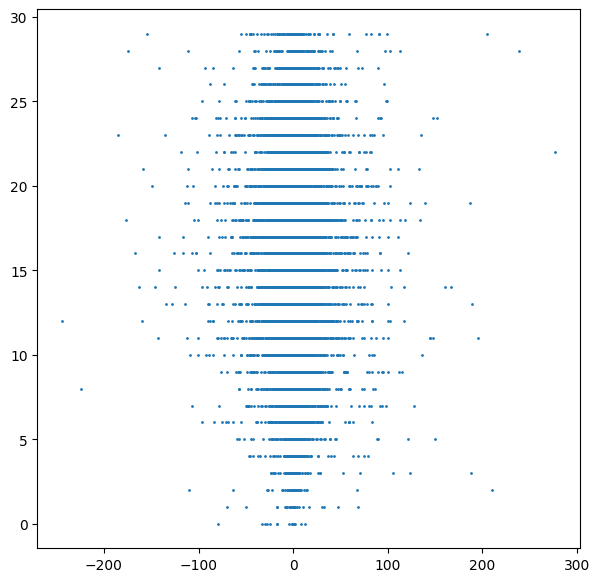

In [40]:
plt.figure(figsize=(7,7))
plt.scatter(x[:],z[:], s=1)
# plt.xlim(-200, 200)
# plt.ylim(-200, 200)

In [41]:
import matplotlib

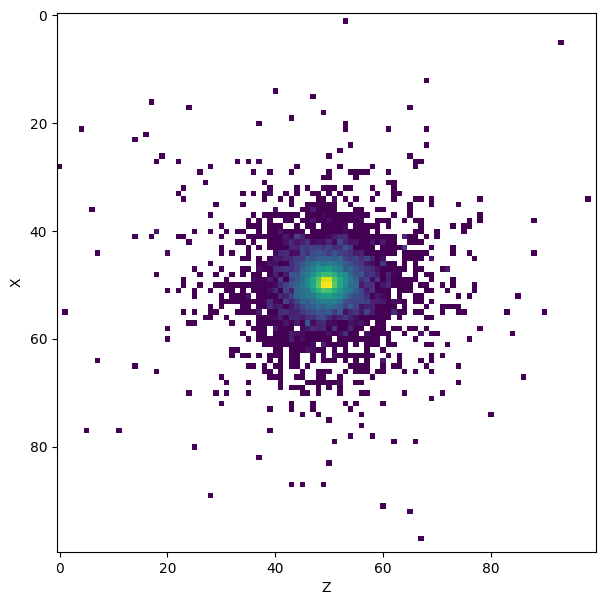

In [42]:
plt.figure(figsize=(7,7))
plt.imshow(H[:, :], norm=matplotlib.colors.LogNorm(vmin=H[H>0].min()*1e6, vmax=H.max()))
plt.xlabel('Z')
plt.ylabel('X')
plt.show()

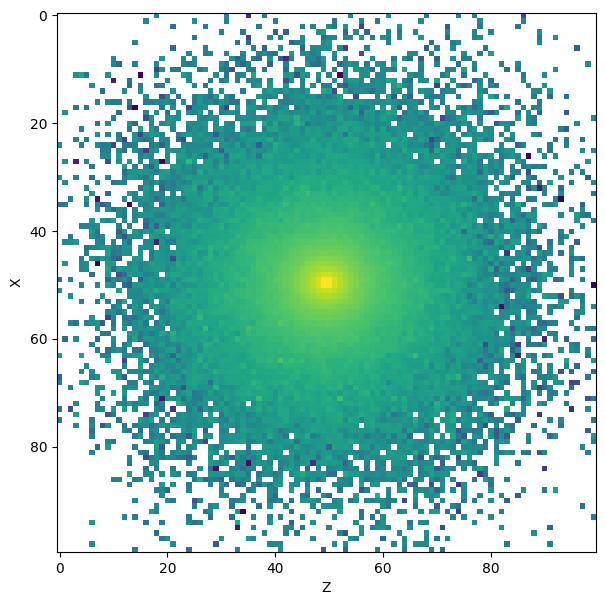

In [90]:
plt.figure(figsize=(7,7))
plt.imshow(H[:, :], norm=matplotlib.colors.LogNorm(vmin=H[H>0].min()*100, vmax=H.max()))
plt.xlabel('Z')
plt.ylabel('X')
plt.show()

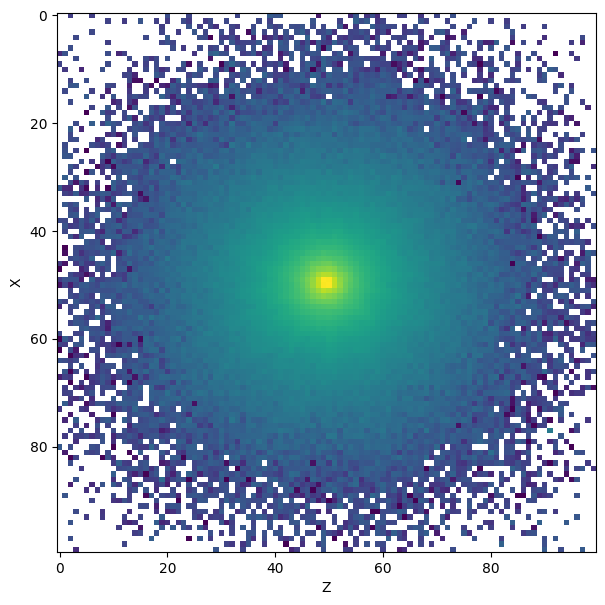

In [68]:
plt.figure(figsize=(7,7))
plt.imshow(H[:, :], norm=matplotlib.colors.LogNorm(vmin=H[H>0].min()*100, vmax=H.max()))
plt.xlabel('Z')
plt.ylabel('X')
plt.show()

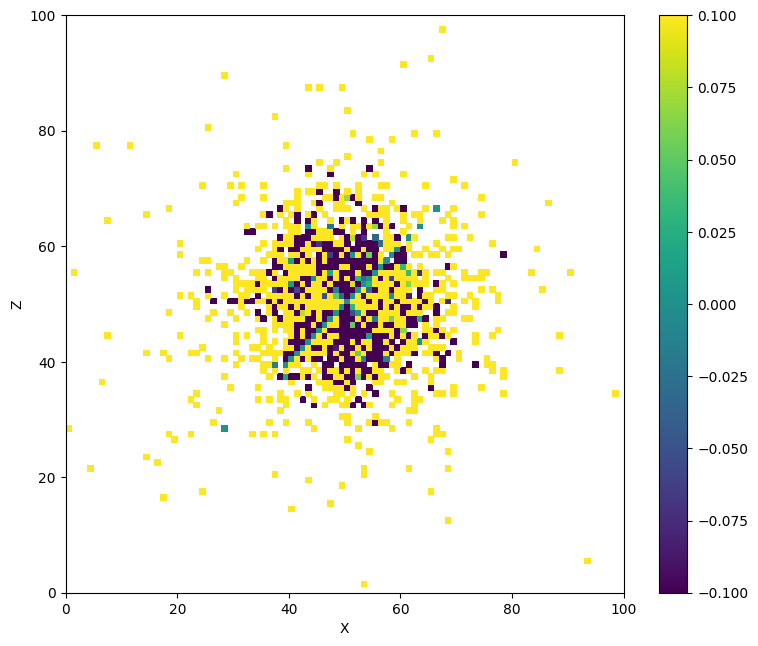

In [43]:
plt.figure(figsize=(9,7.5))
plt.pcolor((H-H.T)/H, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

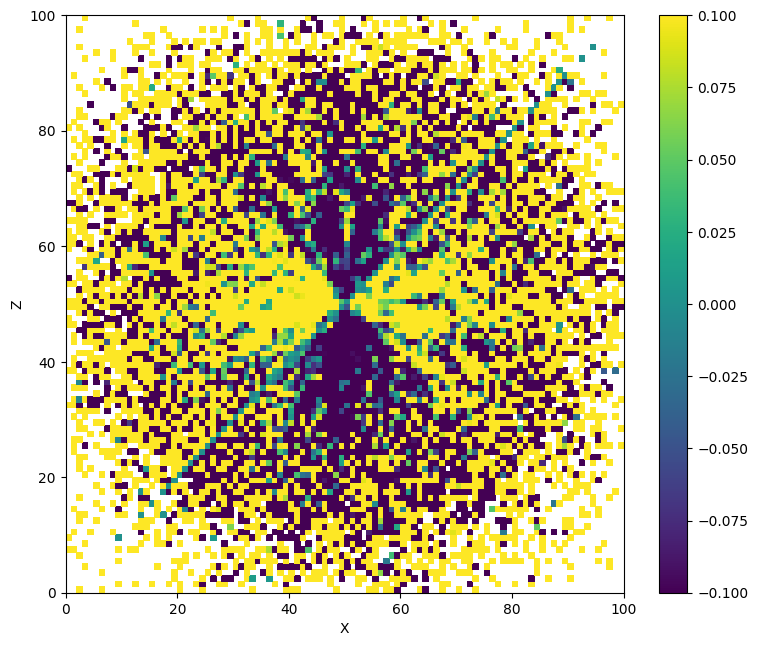

In [69]:
plt.figure(figsize=(9,7.5))
plt.pcolor((H-H.T)/H, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

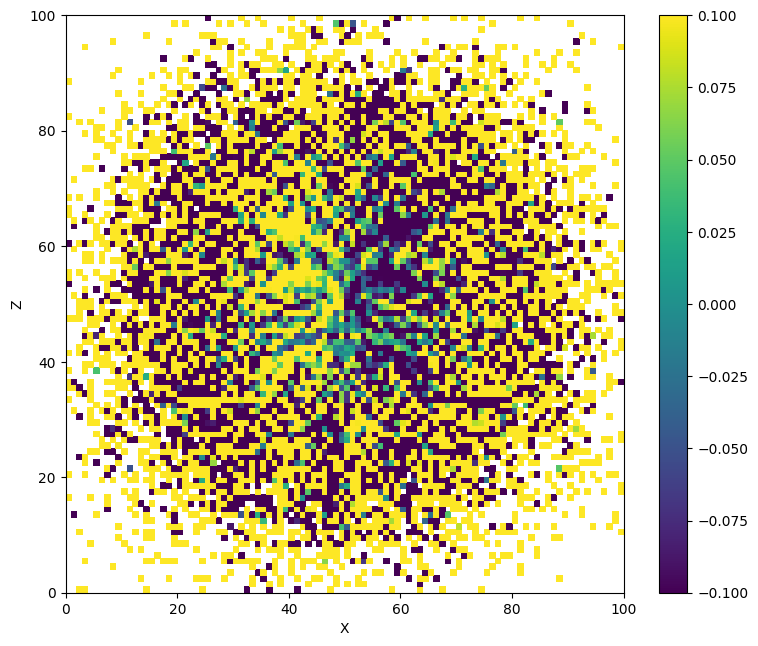

In [62]:
plt.figure(figsize=(9,7.5))
plt.pcolor((H-H[:, ::-1])/H, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

# edm 90 steps

In [35]:
import torch
from torch.nn import Module

from models.common import *
from utils.misc import *

import k_diffusion as K

device = torch.device("cpu")


# @torch.no_grad()
class CaloClouds_2(Module):

    def __init__(self,):
        super(CaloClouds_2, self).__init__()
        
        self.features = 4
        self.sigma_max: float = 80.0 # from configs.py
        self.num_steps: int = 20
        self.rho: float = 7.0
        self.s_churn: float =  0.0   # stochasticity, default 0.0  (if s_churn more than num_steps, it will be clamped to max value)
        self.s_noise: float = 1.0 # 0.97
        self.sigma_min: float = 0.002
        
        
        net = PointwiseNet_kDiffusion(
            point_dim=4, # from configs.py
            context_dim=34 # from configs.py
        )
        
        self.diffusion = Denoiser(
            net,
            sigma_data = 0.5, # from configs.py
            device=device, # from configs.py
            sigma_min=self.sigma_min # from configs.py
        )
        
    
    def get_sigmas_karras(self, n: int, sigma_min: float, sigma_max: float, device: torch.device, rho: float):
        """Constructs the noise schedule of Karras et al. (2022)."""
        ramp = torch.linspace(0, 1, n)
        min_inv_rho = sigma_min ** (1 / rho)
        max_inv_rho = sigma_max ** (1 / rho)
        sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
        return self.append_zero(sigmas).to(device)
    
    def append_zero(self, x: torch.Tensor) -> torch.Tensor :
        return torch.cat([x, x.new_zeros([1])])
    
    def to_d(self, x: torch.Tensor, sigma: torch.Tensor, denoised: torch.Tensor) -> torch.Tensor:
        """Converts a denoiser output to a Karras ODE derivative."""
        return (x - denoised) / self.append_dims(sigma, x.ndim)
    
    def append_dims(self, x: torch.Tensor, target_dims: int) -> torch.Tensor:
        """Appends dimensions to the end of a tensor until it has target_dims dimensions."""
        dims_to_append = target_dims - x.ndim
        if dims_to_append < 0:
            raise ValueError(f'input has {x.ndim} dims but target_dims is {target_dims}, which is less')
        for _ in range(dims_to_append):
            x = x.unsqueeze(-1)
        return x
    
    def sample_heun(
        self,
        x: torch.Tensor,
        sigmas: torch.Tensor,
        context: torch.Tensor,
        s_churn: float = 0.,
        s_tmin: float = 0.,
        s_tmax: float = float('inf'),
        s_noise: float = 1.
    ) -> torch.Tensor:
        
        """Implements Algorithm 2 (Heun steps) from Karras et al. (2022)."""
        
        s_in = x.new_ones([x.shape[0]])

        for i in range(len(sigmas) - 1):
            sigma_current = sigmas[i]
            sigma_next = sigmas[i + 1]
            gamma = min(s_churn / (len(sigmas) - 1), 2 ** 0.5 - 1) if s_tmin <= sigma_current <= s_tmax else 0.
            eps = torch.randn_like(x) * s_noise
            sigma_hat = sigma_current * (gamma + 1)

            if gamma > 0:
                x = x + eps * ((sigma_hat ** 2 - sigma_current ** 2) ** 0.5)

            denoised = self.diffusion(x, sigma_hat * s_in, context)
            d = self.to_d(x, sigma_hat, denoised)

            dt = sigma_next - sigma_hat

            if sigma_next == 0:
                x = x + d * dt  # Euler method
            else:
                x_2 = x + d * dt
                denoised_2 = self.diffusion(x_2, sigma_next * s_in, context)
                d_2 = self.to_d(x_2, sigma_next, denoised_2)
                d_prime = (d + d_2) / 2
                x = x + d_prime * dt  # Heun's method

        return x
    

    @torch.jit.script_method
    def forward(self, cond_feats, num_points: int):

        z = cond_feats  

        x_T = torch.randn([z.size(0), num_points, self.features], device=z.device) * self.sigma_max
        
        sigmas = self.get_sigmas_karras(self.num_steps, self.sigma_min, self.sigma_max, rho=self.rho, device=z.device)

        x_0 = self.sample_heun(x_T, sigmas, context=z, s_churn=self.s_churn, s_noise=self.s_noise)

        return x_0


class Denoiser(Module):
    """A Karras et al. preconditioner for denoising diffusion models."""

    def __init__(self, inner_model, sigma_data=0.5, device='cpu', sigma_min = 0.002):
        super(Denoiser, self).__init__()
        self.inner_model = inner_model
        
        sigma_data = [sigma_data, sigma_data, sigma_data, sigma_data]
        self.sigma_data = torch.tensor(sigma_data, device=device)   # 4,
        self.sigma_min = sigma_min
    
    def get_scalings(self, sigma):   # B, # for edm
        sigma_data = self.sigma_data.expand(sigma.shape[0], -1)   # B, 4
        sigma = self.append_dims(sigma, sigma_data.ndim)  # B, 4
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)  # B, 4
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2) ** 0.5  # B, 4
        c_in = 1 / (sigma ** 2 + sigma_data ** 2) ** 0.5  # B, 4
        return c_skip, c_out, c_in
    
    def append_dims(self, x: torch.Tensor, target_dims: int) -> torch.Tensor:
        """Appends dimensions to the end of a tensor until it has target_dims dimensions."""
        dims_to_append = target_dims - x.ndim
        if dims_to_append < 0:
            raise ValueError(f'input has {x.ndim} dims but target_dims is {target_dims}, which is less')
        for _ in range(dims_to_append):
            x = x.unsqueeze(-1)
        return x
    
    @torch.jit.script_method
    def forward(self, input, sigma: torch.Tensor, context):   # same as "denoise" in KarrasDenoiser of CM code
        
        c_skip, c_out, c_in = [x.unsqueeze(1) for x in self.get_scalings(sigma)]

        return self.inner_model(input * c_in, sigma, context) * c_out + input * c_skip
    


class PointwiseNet_kDiffusion(Module):

    def __init__(self, point_dim, context_dim):
        super(PointwiseNet_kDiffusion, self).__init__()
        time_dim = 32
        fourier_scale = 30   # 1 in k-diffusion, 16 in EDM, 30 in Score-based generative modeling

        self.act = F.leaky_relu
        # self.layers = ModuleList([
        #     ConcatSquashLinear(point_dim, 128, context_dim+time_dim),
        #     ConcatSquashLinear(128, 256, context_dim+time_dim),
        #     ConcatSquashLinear(256, 512, context_dim+time_dim),
        #     ConcatSquashLinear(512, 256, context_dim+time_dim),
        #     ConcatSquashLinear(256, 128, context_dim+time_dim),
        #     ConcatSquashLinear(128, point_dim, context_dim+time_dim)
        # ])
        self.layers = ModuleList([
            ConcatSquashLinear(point_dim, 32, context_dim+time_dim),
            ConcatSquashLinear(32, 64, context_dim+time_dim),
            ConcatSquashLinear(64, 128, context_dim+time_dim),
            ConcatSquashLinear(128, 64, context_dim+time_dim),
            ConcatSquashLinear(64, 32, context_dim+time_dim),
            ConcatSquashLinear(32, point_dim, context_dim+time_dim)
        ])

        self.timestep_embed = nn.Sequential(
            K.layers.FourierFeatures(1, time_dim, std=fourier_scale),   # 1D Fourier features --> with register_buffer, so weights are not trained
            nn.Linear(time_dim, time_dim), # this is a trainable layer
        )
    
    @torch.jit.script_method
    def forward(self, x: torch.Tensor, sigma: torch.Tensor, context: torch.Tensor): # inportant to spesify datatypes
        """
        Args:
            x:  Point clouds at some timestep t, (B, N, d).
            sigma:     Time. (B, ).  --> becomes "sigma" in k-diffusion
            context:  Shape latents. (B, F). 
        """
        batch_size = x.size(0)
        sigma = sigma.view(batch_size, 1, 1)          # (B, 1, 1)
        context = context.view(batch_size, 1, -1)   # (B, 1, F)

        # formulation from EDM paper / k-diffusion
        c_noise = sigma.log() / 4  # (B, 1, 1)
        time_emb = self.act(self.timestep_embed(c_noise))  # (B, 1, T)
        
        # time_emb = torch.cat([beta, torch.sin(beta), torch.cos(beta)], dim=-1)  # (B, 1, 3)
        ctx_emb = torch.cat([time_emb, context], dim=-1)    # (B, 1, F+T)   # TODO: might want to add additional linear embedding net for context or only cond_feats

        out = x
        for i, layer in enumerate(self.layers):
            out = layer(ctx=ctx_emb, x=out)
            if i < len(self.layers) - 1:
                out = self.act(out)
        
        return out

class ConcatSquashLinear(Module):
    def __init__(self, dim_in, dim_out, dim_ctx):
        super(ConcatSquashLinear, self).__init__()
        self._layer = Linear(dim_in, dim_out)
        self._hyper_bias = Linear(dim_ctx, dim_out, bias=False)
        self._hyper_gate = Linear(dim_ctx, dim_out)
    
    @torch.jit.script_method
    def forward(self, ctx, x):
        gate = torch.sigmoid(self._hyper_gate(ctx))
        bias = self._hyper_bias(ctx)
        ret = self._layer(x) * gate + bias
        return ret
    
    



In [36]:
sigmas90 = K.sampling.get_sigmas_karras(cfg.num_steps, cfg.sigma_min, cfg.sigma_max, rho=cfg.rho, device='cpu').numpy()
sigmas30 = K.sampling.get_sigmas_karras(13, cfg.sigma_min, cfg.sigma_max, rho=cfg.rho, device='cpu').numpy()

In [37]:
sigmas30

array([7.9999985e+01, 4.9979328e+01, 3.0183254e+01, 1.7527830e+01,
       9.7232008e+00, 5.1091590e+00, 2.5152194e+00, 1.1431319e+00,
       4.6997926e-01, 1.6975267e-01, 5.1532373e-02, 1.2237655e-02,
       1.9999996e-03, 0.0000000e+00], dtype=float32)

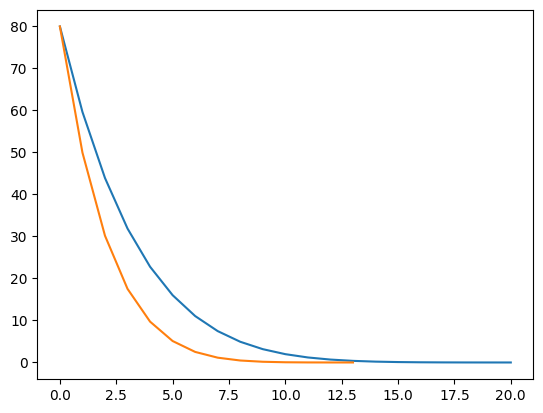

In [38]:
plt.plot(sigmas90)
plt.plot(sigmas30)

In [39]:
cfg.logdir

'/data/dust/user/akorol/logs/cc3/'

In [40]:
# checkpoint = torch.load(f'{cfg.logdir}/CD_ClusteredDS_Pretrained2024_03_26__23_13_09/ckpt_0.000000_1210000.pt', map_location=torch.device(cfg.device))   # max best
# checkpoint = torch.load(cfg.logdir + '/' + 'CaloClouds3_EDM_2025_01_04__01_29_53/ckpt_0.000000_726000.pt', map_location=torch.device(cfg.device))   # max 1200000
checkpoint = torch.load(cfg.logdir + '/' + 'CaloClouds3_EDM_small_2025_01_08__18_03_02/ckpt_0.000000_6000000.pt', map_location=torch.device(cfg.device))   # max 1200000

model = CaloClouds_2().to(torch.device('cpu'))
model.load_state_dict(checkpoint['others']['model_ema'])
model.eval()

CaloClouds_2(
  (diffusion): Denoiser(
    (inner_model): PointwiseNet_kDiffusion(
      (layers): ModuleList(
        (0): ConcatSquashLinear(
          (_layer): Linear(in_features=4, out_features=32, bias=True)
          (_hyper_bias): Linear(in_features=66, out_features=32, bias=False)
          (_hyper_gate): Linear(in_features=66, out_features=32, bias=True)
        )
        (1): ConcatSquashLinear(
          (_layer): Linear(in_features=32, out_features=64, bias=True)
          (_hyper_bias): Linear(in_features=66, out_features=64, bias=False)
          (_hyper_gate): Linear(in_features=66, out_features=64, bias=True)
        )
        (2): ConcatSquashLinear(
          (_layer): Linear(in_features=64, out_features=128, bias=True)
          (_hyper_bias): Linear(in_features=66, out_features=128, bias=False)
          (_hyper_gate): Linear(in_features=66, out_features=128, bias=True)
        )
        (3): ConcatSquashLinear(
          (_layer): Linear(in_features=128, out_featu

In [41]:
inferrer = Inferrer(model, flow_module)

In [42]:
inferrer.get_direction(torch.tensor(0), torch.tensor(10))

tensor([0., 0., 1.])

In [43]:
CC2_container = torch.jit.script(inferrer)

In [44]:
torch.jit.save(CC2_container, '/data/dust/user/akorol/chpts/CaloClouds3_EDM_small_2025_01_08__18_03_02_ckpt_6000000.pt')
# torch.jit.save(CC2_container, 'CCD_ClusteredDS_Pretrained2024_03_26__23_13_09_ckpt_1210000_ShowerFlow_alt1_nb2_calib_cog.pt')


In [45]:
CC2_container_full_load = torch.jit.load('/data/dust/user/akorol/chpts/CaloClouds3_EDM_small_2025_01_08__18_03_02_ckpt_6000000.pt')

In [46]:
x = []
y = []
e = []
for i in tqdm(range(30)):
    fake_shower = CC2_container_full_load(torch.tensor(50), torch.tensor(0), torch.tensor(0))
    fake_shower = fake_shower.numpy()
    x.append(fake_shower[30::4])
    y.append(fake_shower[31::4])
    e.append(fake_shower[33::4])

100%|██████████| 30/30 [00:06<00:00,  4.96it/s]


In [71]:
x = []
y = []
e = []
for i in tqdm(range(50)):
    fake_shower = CC2_container_full_load(torch.tensor(20), torch.tensor(0), torch.tensor(0))
    fake_shower = fake_shower.numpy()
    x.append(fake_shower[30::4])
    y.append(fake_shower[31::4])
    e.append(fake_shower[33::4])

  0%|          | 0/50 [00:00<?, ?it/s]


NameError: name 'CC2_container_full_load' is not defined

In [47]:
x = np.concatenate(x)
y = np.concatenate(y)
e = np.concatenate(e)

In [48]:
np.min(e)

2.381801e-10

In [49]:
H, _, _ = np.histogram2d(x, y, range=((-250,250), (-250,250)), bins=(100, 100), weights=e)


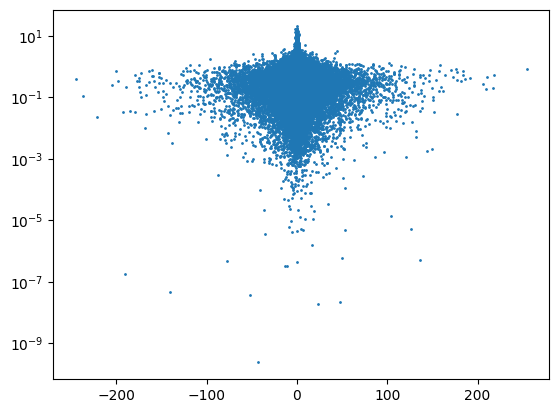

In [50]:
plt.scatter(x, e, s=1)
plt.yscale('log')

In [51]:
x.min(), x.max()

(-244.9576, 254.3802)

In [52]:
y.min(), y.max()

(-279.02197, 224.82477)

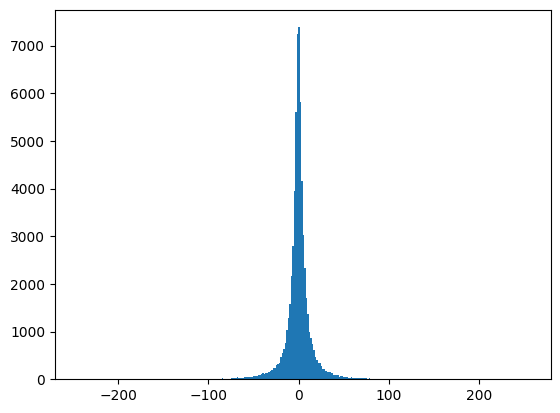

In [53]:
plt.hist(x, bins=300);

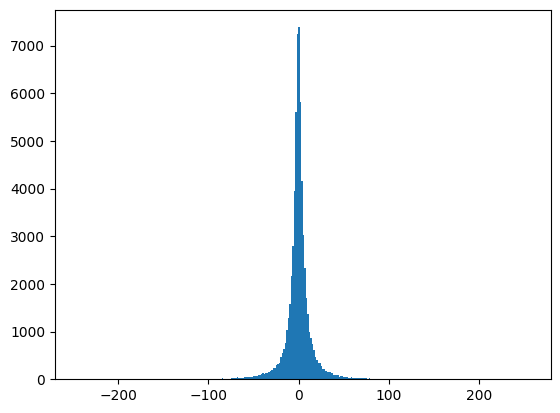

In [54]:
plt.hist(x, bins=300);

In [55]:
import matplotlib

In [56]:
H[H<0] = 0

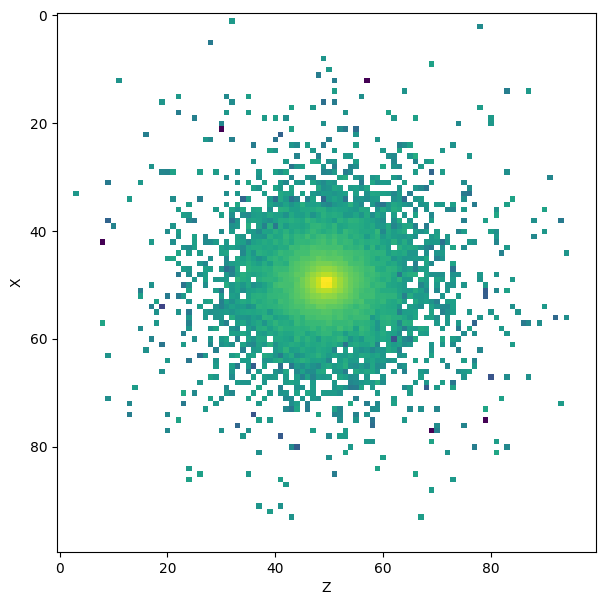

In [57]:
plt.figure(figsize=(7,7))
plt.imshow(H[:, :], norm=matplotlib.colors.LogNorm(vmin=H[H>0].min()*100, vmax=H.max()))
plt.xlabel('Z')
plt.ylabel('X')
plt.show()

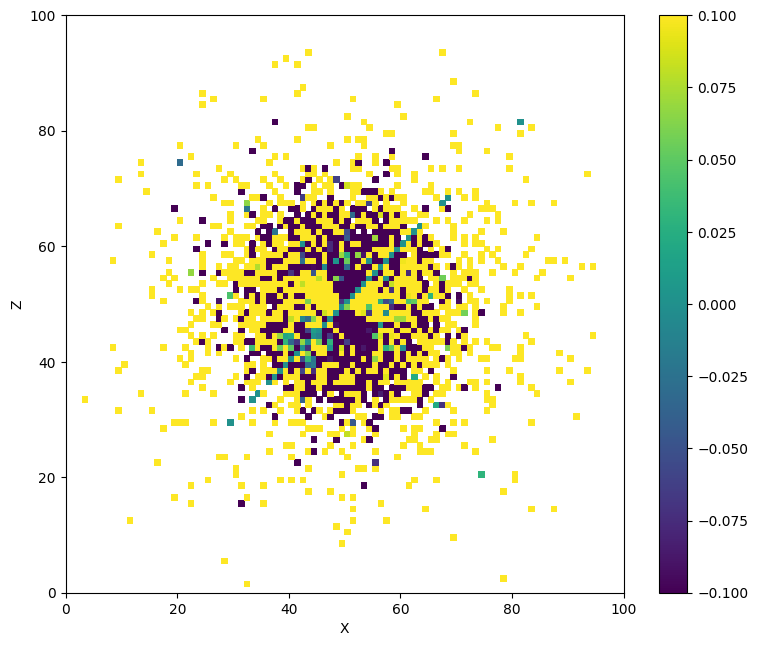

In [58]:
plt.figure(figsize=(9,7.5))
plt.pcolor((H-H.T)/H, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

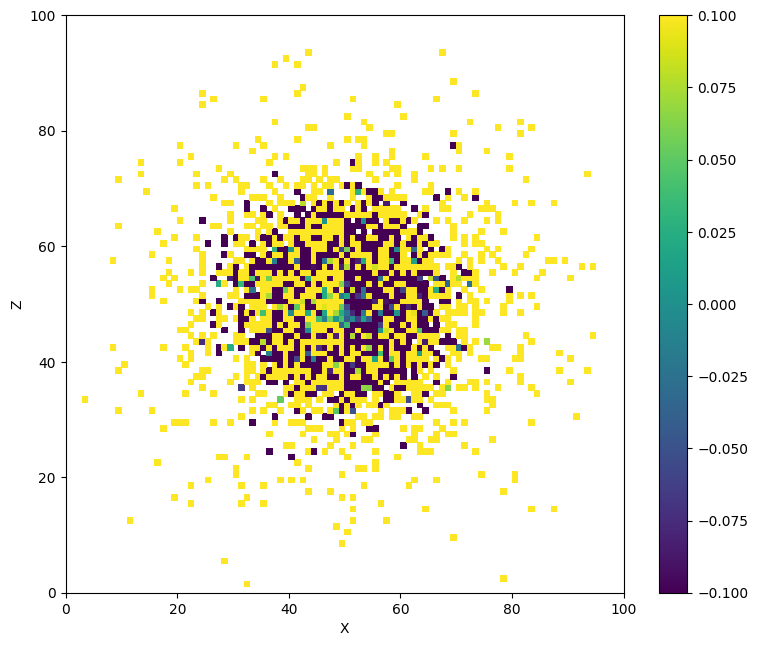

In [59]:
plt.figure(figsize=(9,7.5))
plt.pcolor((H-H[:, ::-1])/H, vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

In [60]:
9103.22/60/60

2.5286722222222218

In [315]:
%%timeit
fake_shower = CC2_container_full_load(torch.tensor(50), torch.tensor(0), torch.tensor(0))

1.48 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
x = []
y = []
z = []
e = []
for i in tqdm(range(1)):
    fake_shower = CC2_container_full_load(torch.tensor(50), torch.tensor(45), torch.tensor(180))
    fake_shower = fake_shower.numpy()
    x.append(fake_shower[30::4])
    y.append(fake_shower[31::4])
    z.append(fake_shower[32::4])
    e.append(fake_shower[33::4])

x = np.concatenate(x)
y = np.concatenate(y)
z = np.concatenate(z)
e = np.concatenate(e)

100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


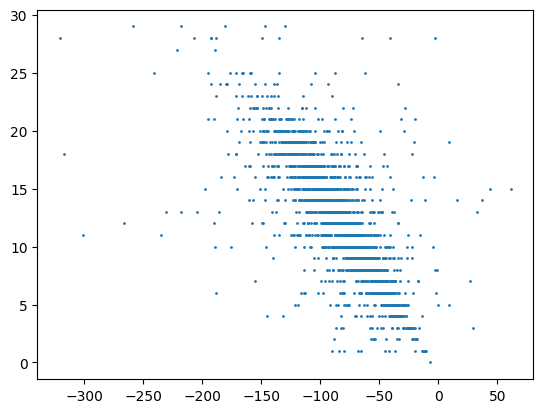

In [62]:
plt.scatter(x,z, s=1)